In [2]:
# Importy
import pandas as pd
import numpy as np
import boto3
import os
from dotenv import load_dotenv
import s3fs
import datetime
from pycaret.regression import RegressionExperiment


In [3]:
# Polączenie z S3
load_dotenv()

BUCKET_NAME = "maraton"

# klient S3 (Digital Ocean Spaces)
s3 = boto3.client(
    "s3",
    region_name="fra1",
    endpoint_url="https://fra1.digitaloceanspaces.com",
    aws_access_key_id=os.getenv("SPACES_KEY"),
    aws_secret_access_key=os.getenv("SPACES_SECRET")
)

print("✔ Połączenie S3 OK.")

✔ Połączenie S3 OK.


In [4]:
# Wczytanie plików csv do analizy
def load_csv_from_s3(filename):
    fs = s3fs.S3FileSystem(
        key=os.getenv("SPACES_KEY"),
        secret=os.getenv("SPACES_SECRET"),
        client_kwargs={"endpoint_url": "https://fra1.digitaloceanspaces.com"}
    )
    path = f"{BUCKET_NAME}/{filename}"
    return pd.read_csv(
        f"s3://{path}",
        sep=";",
        na_values=["", " ", "-", "nan", "NA", "DNS", "DNF"]
    )

df_2023 = load_csv_from_s3("halfmarathon_wroclaw_2023__final.csv")
df_2024 = load_csv_from_s3("halfmarathon_wroclaw_2024__final.csv")

print(df_2023.shape, df_2024.shape)


(8950, 27) (13007, 27)


In [5]:
# Dodanie kolumny Rok do każdego z plików
df_2023["Rok"] = 2023
df_2024["Rok"] = 2024


In [6]:
df_2023.sample(5)

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Rok
4760,4761.0,3242,ANNA,BILIŃSKA,WROCŁAW,POL,NaN,K,846.0,K40,...,01:27:54,5280.0,5.596667,01:58:51,4842.0,6.190000,-0.013000,02:04:14,5.889231,2023
1116,1117.0,520,GRZEGORZ,MAJEWSKI,NYSA,POL,ARKADIUSZ GARDZIELEWSKI RUNNING TEAM,M,1032.0,M50,...,01:10:42,1159.0,4.906667,01:36:53,1110.0,5.236667,0.044067,01:41:42,4.821048,2023
7794,7795.0,3817,MONIKA,OCHENKOWSKA,KOBYŁKA,POL,NaN,K,2154.0,K40,...,01:46:26,7685.0,7.516667,02:32:20,7769.0,9.180000,0.154933,02:41:01,7.632930,2023
439,440.0,6876,PAWEŁ,KOWALKOWSKI,GOSTYNIN,POL,RYKOWISKO TEAM,M,416.0,M40,...,01:04:08,433.0,4.510000,01:28:25,441.0,4.856667,0.049533,01:32:46,4.397567,2023
6546,6547.0,6334,TOMASZ,MUCHA,ŻÓRAWINA,POL,NaN,M,5010.0,M40,...,01:32:33,6135.0,6.590000,02:12:18,6505.0,7.950000,0.135333,02:19:33,6.615312,2023


In [7]:
df_2024.sample(5)

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Rok
10093,10096.0,11507,PAWEŁ,BERESTECKI,WROCŁAW,POL,NaN,M,7151.0,M30,...,01:52:31,9936.0,7.860000,02:41:19,10092.0,9.760000,0.166200,02:52:08,8.159912,2024
723,724.0,2777,JAKUB,BARTNICKI,WROCŁAW,POL,NaN,M,689.0,M20,...,01:06:40,642.0,4.530000,01:31:24,723.0,4.946667,0.032667,01:36:45,4.586395,2024
6359,6360.0,4832,PIOTR,BORYS,PACZKÓW,POL,TRUNKOWCY,M,5127.0,M30,...,01:29:54,6651.0,6.070000,02:01:14,6400.0,6.266667,0.017600,02:08:22,6.085170,2024
2046,2047.0,4349,ALEKSANDER,PRUS,WROCŁAW,POL,NaN,M,1869.0,M20,...,01:15:55,2391.0,5.156667,01:41:33,2134.0,5.126667,0.006200,01:47:05,5.076242,2024
9311,9312.0,11180,ANNA,CZYŚCIAK,WROCŁAW,POL,NaN,K,2549.0,K20,...,01:43:40,9203.0,7.536667,02:24:19,9392.0,8.130000,0.122200,02:31:54,7.200758,2024


In [8]:
# Połączenie w jeden df
df = pd.concat([df_2023, df_2024], ignore_index=True)
print(df.shape)
df.head()

(21957, 28)


,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Rok
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509,2023
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875,2023
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475,2023
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963,2023
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654,2023


In [9]:
# Funkcja konwersacji czasu na sekundy
def time_to_sec(x):
    """Konwersja hh:mm:ss → sekundy. Błędne formaty → NaN."""
    if pd.isna(x):
        return np.nan

    x = str(x).strip()

    # musi mieć dwa dwukropki
    if x.count(":") != 2:
        return np.nan
    
    try:
        h, m, s = x.split(":")
        return int(h) * 3600 + int(m) * 60 + int(s)
    except:
        return np.nan


time_cols = ["5 km Czas", "10 km Czas", "15 km Czas", "20 km Czas", "Czas"]

for col in time_cols:
    df[col] = df[col].apply(time_to_sec)

df = df.dropna(subset=time_cols)
print(df.shape)
df.head()


(18377, 28)


,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Rok
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2687.0,1.0,3.106667,3703.0,1.0,3.386667,0.031400,3899.0,3.080509,2023
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2726.0,2.0,3.143333,3788.0,2.0,3.540000,0.038000,3983.0,3.146875,2023
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,2854.0,3.0,3.236667,3909.0,3.0,3.516667,0.024067,4104.0,3.242475,2023
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,2929.0,5.0,3.330000,4014.0,4.0,3.616667,0.025467,4216.0,3.330963,2023
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,2971.0,7.0,3.386667,4047.0,5.0,3.586667,0.023000,4227.0,3.339654,2023


In [10]:
# Wyliczenie wieku
def age_from_category(cat):
    try:
        return int(cat[1:])   # M30 → 30
    except:
        return np.nan

df["Wiek"] = df["Kategoria wiekowa"].apply(age_from_category)
df = df.dropna(subset=["Wiek"])
df["Wiek"] = df["Wiek"].astype(int)

df.head()


,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Rok,Wiek
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,1.0,3.106667,3703.0,1.0,3.386667,0.031400,3899.0,3.080509,2023,30
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.0,3.143333,3788.0,2.0,3.540000,0.038000,3983.0,3.146875,2023,30
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.0,3.236667,3909.0,3.0,3.516667,0.024067,4104.0,3.242475,2023,20
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,5.0,3.330000,4014.0,4.0,3.616667,0.025467,4216.0,3.330963,2023,30
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,7.0,3.386667,4047.0,5.0,3.586667,0.023000,4227.0,3.339654,2023,20


In [11]:
# Utworzenie df_train do trenownaia modelu
df_train = df[[
    "Płeć",
    "Wiek",
    "5 km Czas",
    "10 km Czas",
    "15 km Czas",
    "20 km Czas",
    "Czas"
]].copy()

df_train = df_train.rename(columns={"Czas": "czas_s"})
print(df_train.shape)
df_train.head()


(18360, 7)


,Płeć,Wiek,5 km Czas,10 km Czas,15 km Czas,20 km Czas,czas_s
0,M,30,877.0,1755.0,2687.0,3703.0,3899.0
1,M,30,888.0,1783.0,2726.0,3788.0,3983.0
2,M,20,946.0,1883.0,2854.0,3909.0,4104.0
3,M,30,971.0,1930.0,2929.0,4014.0,4216.0
4,M,20,972.0,1955.0,2971.0,4047.0,4227.0


In [12]:
# Setup 
exp = RegressionExperiment()

exp.setup(
    data=df_train,
    target="czas_s",
    categorical_features=["Płeć"],
    normalize=False,
    polynomial_features=False,
    remove_outliers=False,
    session_id=123,
    verbose=False
)

allowed_models = [
    "huber", "rf", "et", "en", "lasso",
    "lr", "ridge", "knn", "gbr"
]

best = exp.compare_models(
    sort="MAE",
    include=allowed_models,
    turbo=False
)

best


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,37.2545,5245.4327,64.7129,0.9965,0.0084,0.0050,0.6880
huber,Huber Regressor,37.2555,4745.3042,60.7085,0.9968,0.0076,0.0049,0.3150
et,Extra Trees Regressor,37.9509,5483.1579,66.5776,0.9964,0.0087,0.0051,0.3390
en,Elastic Net,37.9900,4563.1107,58.9276,0.9970,0.0075,0.0051,0.0250
lasso,Lasso Regression,37.9994,4564.1755,58.9378,0.9970,0.0075,0.0051,0.0250
lr,Linear Regression,38.0803,4557.9496,58.8802,0.9970,0.0075,0.0051,0.0160
ridge,Ridge Regression,38.0803,4557.9494,58.8802,0.9970,0.0075,0.0051,0.0150
knn,K Neighbors Regressor,38.7021,5751.7995,68.8111,0.9962,0.0090,0.0051,0.0190
gbr,Gradient Boosting Regressor,41.1160,5363.2153,65.6769,0.9964,0.0085,0.0055,0.2090


RandomForestRegressor(n_jobs=-1, random_state=123)

In [ ]:
# Finalizacja modelu + zapis lokanie
final_model = exp.finalize_model(best)

exp.save_model(final_model, "models/model_polmaraton_splity")

print("✔ Zapisano lokalnie jako model_polmaraton_splity.pkl")


Transformation Pipeline and Model Successfully Saved
✔ Zapisano lokalnie jako model_polmaraton_splity.pkl


In [14]:
# Zapis modelu do S3
s3.upload_file(
    Filename="models/model_polmaraton_splity.pkl",
    Bucket=BUCKET_NAME,
    Key="models/model_polmaraton_splity.pkl"
)

print("✔ Zapisano do S3.")


✔ Zapisano do S3.


In [15]:
# Predykcja
def predict(sex, age, t5):
    row = pd.DataFrame([{
        "Płeć": sex,
        "Wiek": age,
        "5 km Czas": t5,
        "10 km Czas": t5 * 2,
        "15 km Czas": t5 * 3,
        "20 km Czas": t5 * 4,
    }])

    res = exp.predict_model(final_model, data=row)
    sec = int(res["prediction_label"].iloc[0])
    return str(datetime.timedelta(seconds=sec))

print("M, 35, 1500 →", predict("M", 35, 500))
print("M, 35, 3500 →", predict("M", 35, 3500))
print("K, 28, 1800 →", predict("K", 28, 1800))


M, 35, 1500 → 1:04:41


M, 35, 3500 → 3:30:34


K, 28, 1800 → 2:06:01


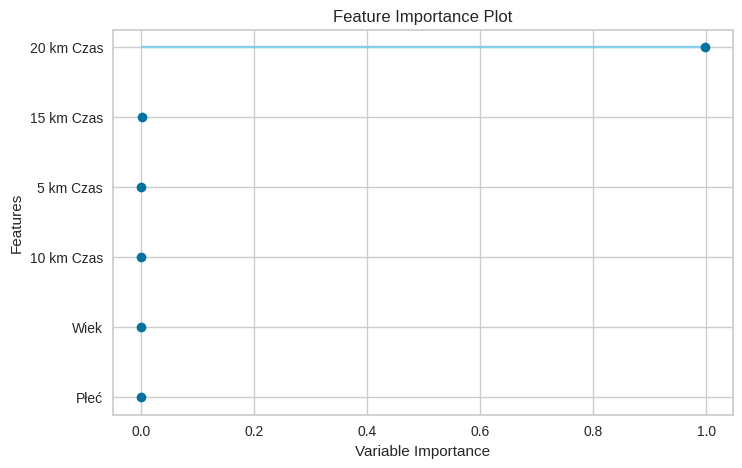

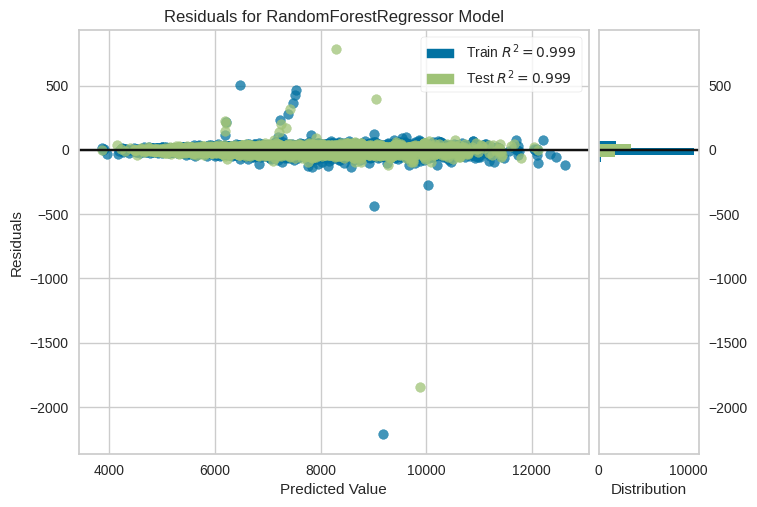

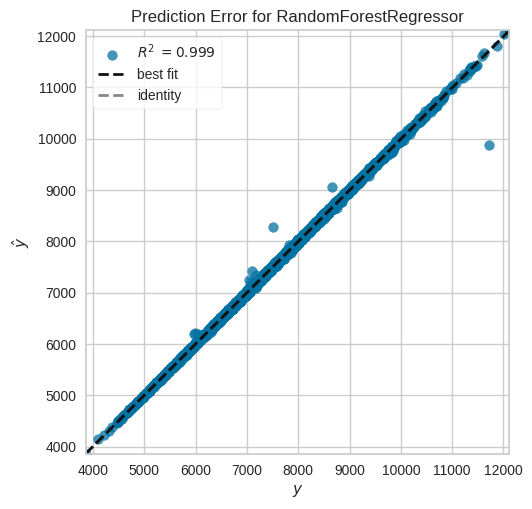

In [16]:
# Wykresy
exp.plot_model(final_model, plot="feature")
exp.plot_model(final_model, plot="residuals")
exp.plot_model(final_model, plot="error")
